In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# when running on CPU, I found that performance is pretty much the same as with many cores
torch.set_num_threads(1)

# Create task and RNN

In [21]:
from modular_rnn.connections import ConnectionConfig
from modular_rnn.models import MultiRegionRNN
from modular_rnn.loss_functions import TolerantLoss

Set parameters

In [22]:
# time constant of each neuron's the dynamics
tau = 100

# timestep of the simulation
dt = 5

# need this
alpha = dt / tau

# tolerance in degrees in Dekleva et al 2016's uncertainty task
tolerance = 5.

# noise in the dynamics
noise = 0.05

# activation function of the neurons
nonlin_fn = F.relu

In [23]:
# length of each trial
L = 1200

# number of trials in a batch
batch_size = 64

# special loss for the uncertainty task
loss_fn = TolerantLoss(tolerance, 'hand')

Create task

In [24]:
from modular_rnn.tasks import CossinUncertaintyTaskWithReachProfiles

task = CossinUncertaintyTaskWithReachProfiles(dt, tau, L, batch_size)

Create RNN

In [25]:
# dictionary defining the modules in the RNN
# here we'll have a single region called motor_cortex
regions_config_dict = {
    'motor_cortex' : {
        'n_neurons' : 50,
        'alpha' : alpha,
        'p_rec': 1.,
        'rec_rank' : 1,
        'dynamics_noise' : noise,
    }
}

# name and dimensionality of the outputs we want the RNN to produce
output_dims = task.output_dims
# name and dimensionality of the inputs we want the RNN to receive
input_dims = task.input_dims

In [26]:
rnn = MultiRegionRNN(
     input_dims,
     output_dims,
     alpha,
     nonlin_fn,
     regions_config_dict, 
     connection_configs = [],
     input_configs = [
        ConnectionConfig('cue_slices_cossin', 'motor_cortex'),
        ConnectionConfig('go_cue', 'motor_cortex'),
     ],
     output_configs = [
         ConnectionConfig('motor_cortex', 'hand'),
     ],
     feedback_configs = []
)

# Train

  0%|          | 0/500 [00:00<?, ?it/s]

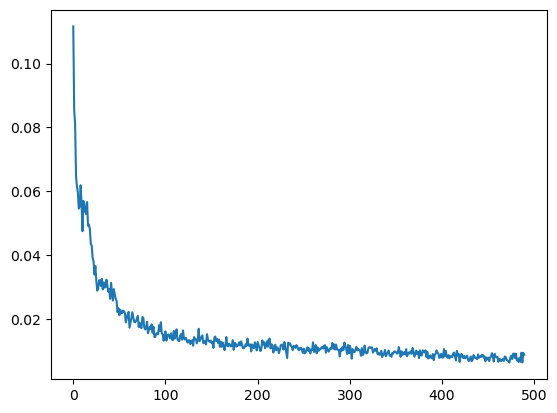

In [27]:
from modular_rnn.training import train

losses = train(rnn, task, 500, loss_fn)
plt.plot(losses[10:]);

# Test the model's behavior on some test trials

Run a few batches of test trials

In [28]:
from modular_rnn.testing import run_test_batches

test_df = run_test_batches(10, rnn, task)

Produced reach direction vs. target direction

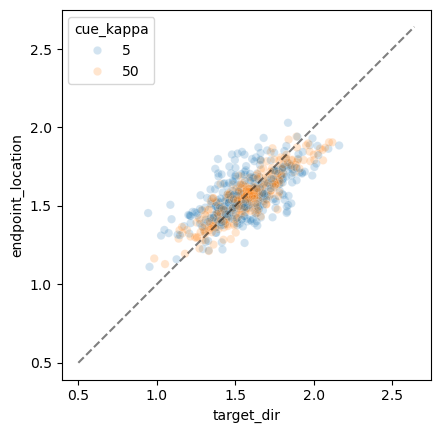

In [29]:
ax = sns.scatterplot(x = 'target_dir', y = 'endpoint_location', hue = 'cue_kappa', data = test_df, palette = 'tab10', alpha = 0.2)

ax.plot([0+0.5, np.pi-0.5], [0+0.5, np.pi-0.5], color = 'black', linestyle = '--', alpha = 0.5)

ax.set_aspect('equal')

Produced "hand" trajectories

Text(0, 0.5, 'y')

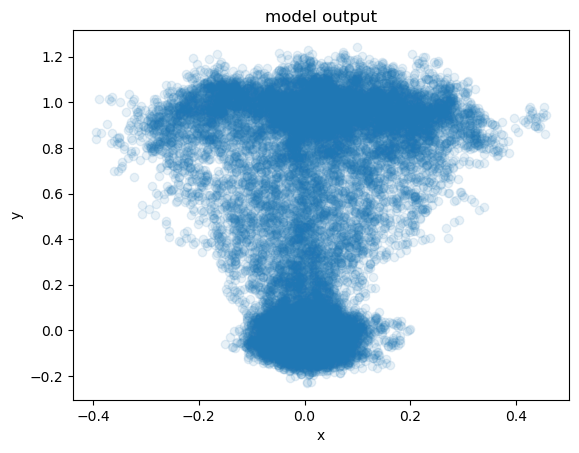

In [30]:
fig, ax = plt.subplots()

for arr in test_df.hand_model_output.values[:100]:
    ax.scatter(*arr.T, alpha = 0.1, color = 'tab:blue')
    
ax.set_title('model output')
ax.set_xlabel('x')
ax.set_ylabel('y')

Ratio of successful trials

In [31]:
np.mean(np.abs(test_df.endpoint_location - test_df.target_dir) < np.deg2rad(tolerance))

0.515625

Rank of the recurrent weight matrix

In [32]:
torch.linalg.matrix_rank(rnn.regions['motor_cortex'].W_rec)

tensor(50)